# Прогнозирование временных рядов: Среднесуточная температура в Дели

## Введение

В данной работе мы рассмотрим задачу прогнозирования временных рядов. Временной ряд представляет собой последовательность данных, измеренных через равные промежутки времени. Прогнозирование таких рядов имеет важное значение во многих областях, таких как экономика, метеорология, финансы и производство.

### Цель работы

Целью данной работы является:
1.  Выбрать и проанализировать набор данных временного ряда.
2.  Визуализировать временной ряд и его ключевые характеристики.
3.  Разделить данные на обучающую и тестовую выборки.
4.  Построить и обучить две модели прогнозирования:
    * Модель ARIMA (Авторегрессионное интегрированное скользящее среднее).
    * Модель на основе символьной регрессии.
5.  Визуализировать результаты прогнозирования.
6.  Оценить качество прогнозов с использованием метрики MSE (Mean Squared Error).

### Используемый набор данных

Для решения поставленной задачи был выбран набор данных **"Daily Climate time series data"** с платформы Kaggle. Этот датасет содержит ежедневные климатические данные для города Дели за период с 1 января 2013 года по 1 января 2017 года.

* **Ссылка на датасет:** [https://www.kaggle.com/datasets/sumanthvrao/daily-climate-time-series-data](https://www.kaggle.com/datasets/sumanthvrao/daily-climate-time-series-data)

Мы будем использовать файл `DailyDelhiClimateTrain.csv` и сфокусируемся на прогнозировании среднесуточной температуры (`meantemp`).

**Важно:** Перед запуском кода убедитесь, что вы скачали файл `DailyDelhiClimateTrain.csv` и поместили его в ту же директорию, что и данный Jupyter Notebook, или укажите правильный путь к файлу.

## 1. Загрузка и предварительная обработка данных

### 1.1. Импорт библиотек

Сначала импортируем все необходимые библиотеки. Если какие-то из них не установлены, вам потребуется их установить с помощью `pip` (например, `pip install pandas matplotlib statsmodels scikit-learn gplearn`).

In [51]:
# Основные библиотеки для работы с данными
import pandas as pd
import numpy as np

# Библиотеки для визуализации
import matplotlib.pyplot as plt
import seaborn as sns

# Библиотеки для анализа временных рядов
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima.model import ARIMA

# Библиотеки для машинного обучения и оценки
from sklearn.metrics import mean_squared_error
from gplearn.genetic import SymbolicRegressor

# Настройки для визуализации
plt.style.use('seaborn-v0_8-whitegrid')
plt.rcParams['figure.figsize'] = (15, 7)

# Отключение предупреждений (для чистоты вывода)
import warnings
warnings.filterwarnings('ignore')

### 1.2. Загрузка данных

Загрузим данные из CSV-файла и преобразуем столбец `date` в формат datetime, установив его в качестве индекса.

In [52]:
# Укажите путь к вашему файлу
file_path = 'DailyDelhiClimateTrain.csv'

# Загрузка данных
df = pd.read_csv(file_path)

# Преобразование столбца 'date' в datetime и установка его как индекса
df['date'] = pd.to_datetime(df['date'])
df.set_index('date', inplace=True)

# Выбор целевой переменной - среднесуточной температуры
ts_data = df[['meantemp']]

# Вывод первых нескольких строк и информации о данных
print("Первые 5 строк данных:")
print(ts_data.head())
print("\nИнформация о данных:")
ts_data.info()

Первые 5 строк данных:
             meantemp
date                 
2013-01-01  10.000000
2013-01-02   7.400000
2013-01-03   7.166667
2013-01-04   8.666667
2013-01-05   6.000000

Информация о данных:
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1462 entries, 2013-01-01 to 2017-01-01
Data columns (total 1 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   meantemp  1462 non-null   float64
dtypes: float64(1)
memory usage: 22.8 KB


### 1.3. Проверка пропусков

Убедимся, что в нашем временном ряду нет пропущенных значений.

In [53]:
missing_values = ts_data.isnull().sum()
print(f"\nКоличество пропущенных значений:\n{missing_values}")

# Если есть пропуски, можно использовать интерполяцию или заполнение средним
# В данном случае, если бы они были, мы могли бы сделать так:
# ts_data.fillna(ts_data.mean(), inplace=True)
# Но, судя по выводу info(), пропусков нет, что хорошо.


Количество пропущенных значений:
meantemp    0
dtype: int64


## 2. Исследовательский анализ данных (EDA)

### 2.1. Визуализация временного ряда

Построим график нашего временного ряда, чтобы увидеть общие тенденции и сезонность.

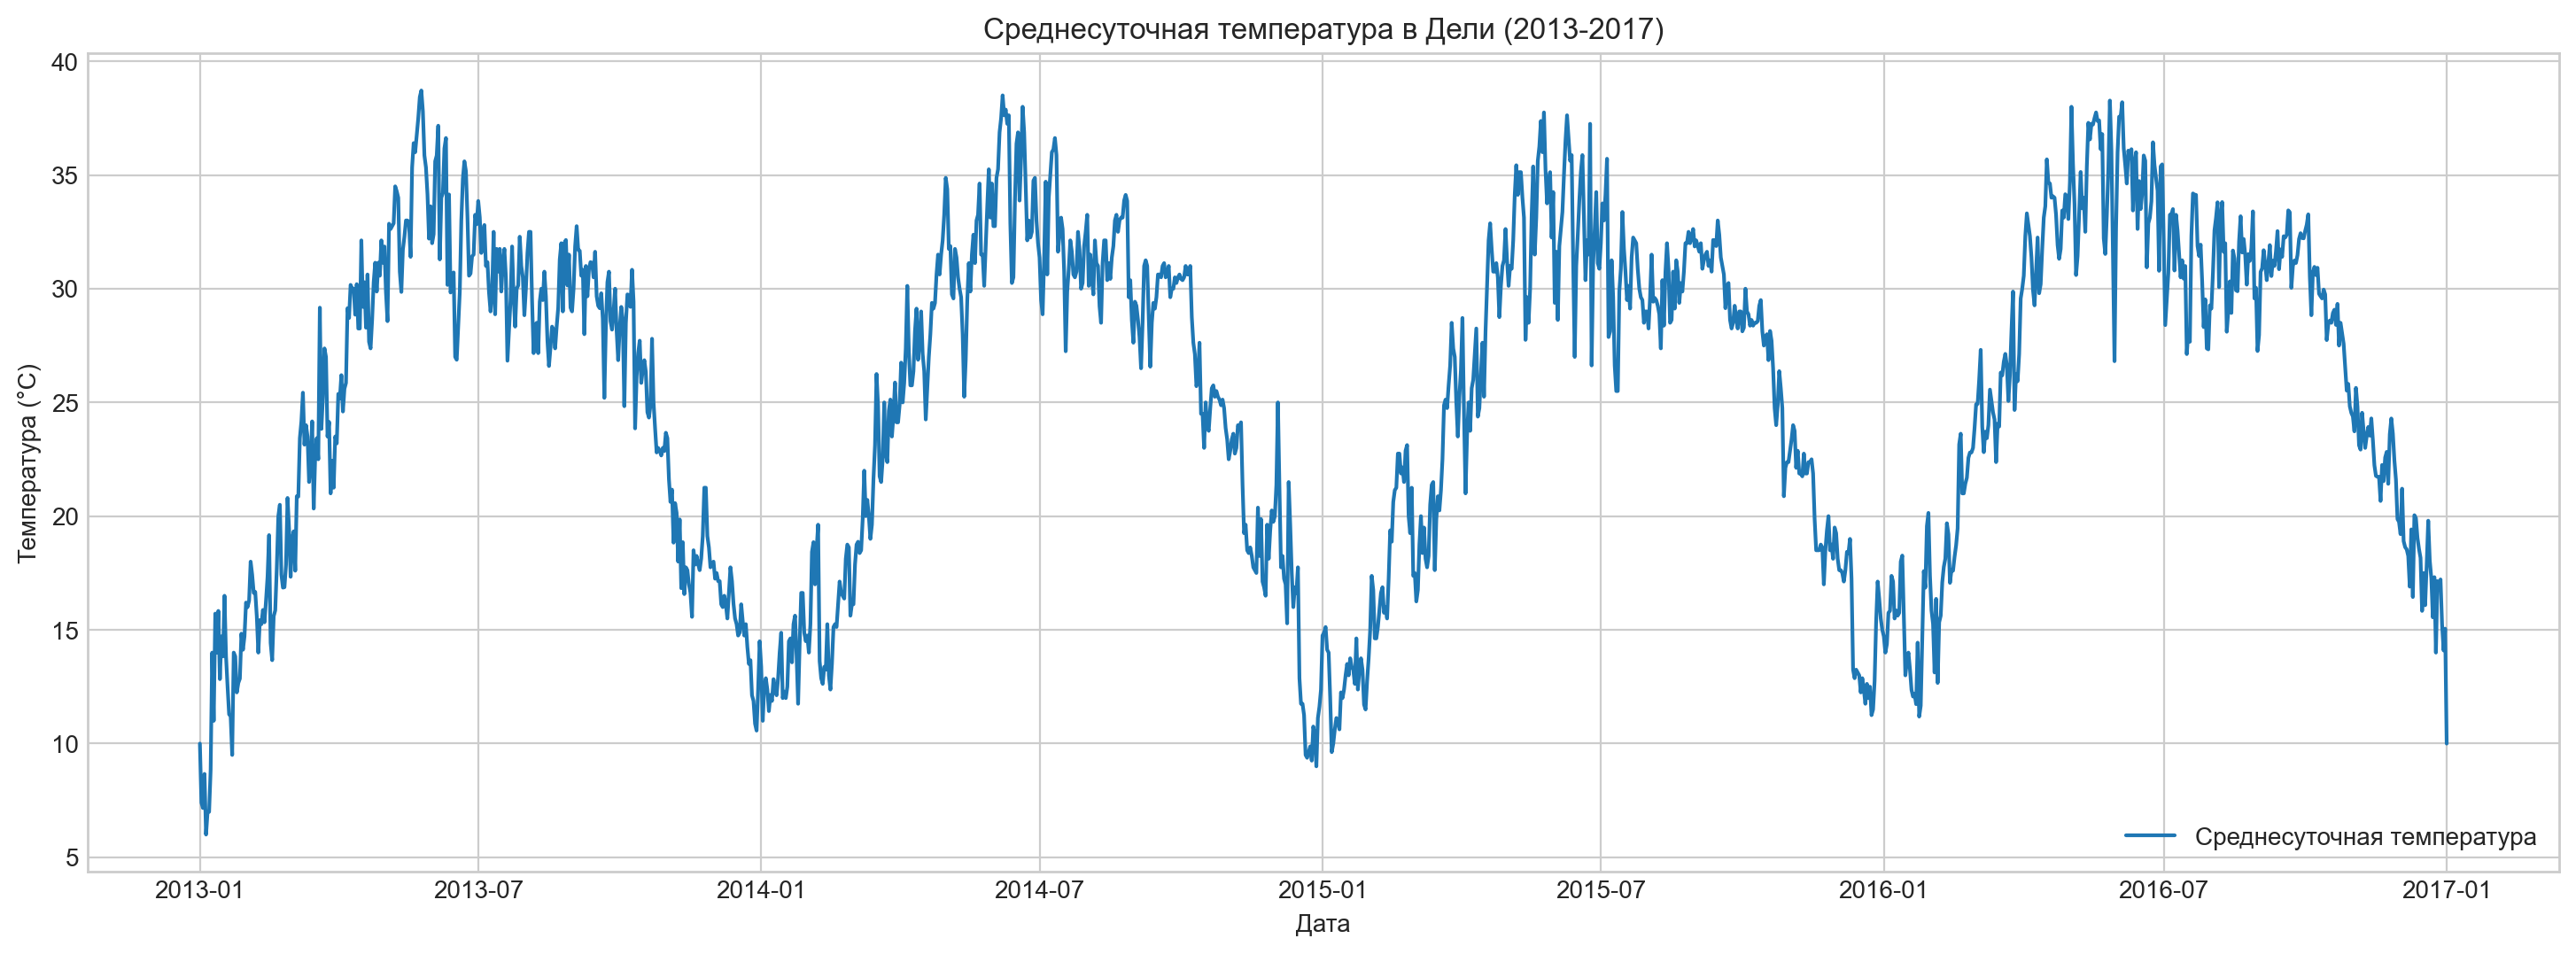

In [54]:
plt.figure(figsize=(18, 6))
plt.plot(ts_data.index, ts_data['meantemp'], label='Среднесуточная температура')
plt.title('Среднесуточная температура в Дели (2013-2017)')
plt.xlabel('Дата')
plt.ylabel('Температура (°C)')
plt.legend()
plt.show()

На графике отчетливо видна годовая сезонность: пики температуры приходятся на летние месяцы, а спады - на зимние. Также можно заметить некоторый восходящий тренд, хотя он не очень выражен.

### 2.2. Анализ стационарности

Многие модели временных рядов (включая ARIMA) требуют, чтобы ряд был стационарным. Стационарный ряд — это ряд, у которого статистические свойства (среднее, дисперсия, автокорреляция) не изменяются со временем.

Мы используем **Расширенный тест Дики-Фуллера (ADF)** для проверки стационарности. Нулевая гипотеза (H0) теста заключается в том, что ряд не является стационарным (имеет единичный корень). Если p-value меньше определенного уровня значимости (обычно 0.05), мы отвергаем H0 и считаем ряд стационарным.

In [55]:
def test_stationarity(timeseries):
    """Функция для проведения теста Дики-Фуллера"""
    print('Результаты теста Дики-Фуллера:')
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic', 'p-value', '#Lags Used', 'Number of Observations Used'])
    for key, value in dftest[4].items():
        dfoutput['Critical Value (%s)' % key] = value
    print(dfoutput)
    
    if dftest[1] <= 0.05:
        print("\nВывод: Ряд стационарен (p-value <= 0.05)")
    else:
        print("\nВывод: Ряд не стационарен (p-value > 0.05)")

test_stationarity(ts_data['meantemp'])

Результаты теста Дики-Фуллера:
Test Statistic                   -2.021069
p-value                           0.277412
#Lags Used                       10.000000
Number of Observations Used    1451.000000
Critical Value (1%)              -3.434865
Critical Value (5%)              -2.863534
Critical Value (10%)             -2.567832
dtype: float64

Вывод: Ряд не стационарен (p-value > 0.05)


### 2.3. Автокорреляционная и Частная автокорреляционная функции (ACF и PACF)

Графики ACF и PACF помогают определить параметры `p` (порядок AR) и `q` (порядок MA) для модели ARIMA.
* **ACF (Автокорреляционная функция):** Показывает корреляцию ряда с его прошлыми значениями (лагами).
* **PACF (Частная автокорреляционная функция):** Показывает корреляцию ряда с его лагами, но с учетом влияния промежуточных лагов.

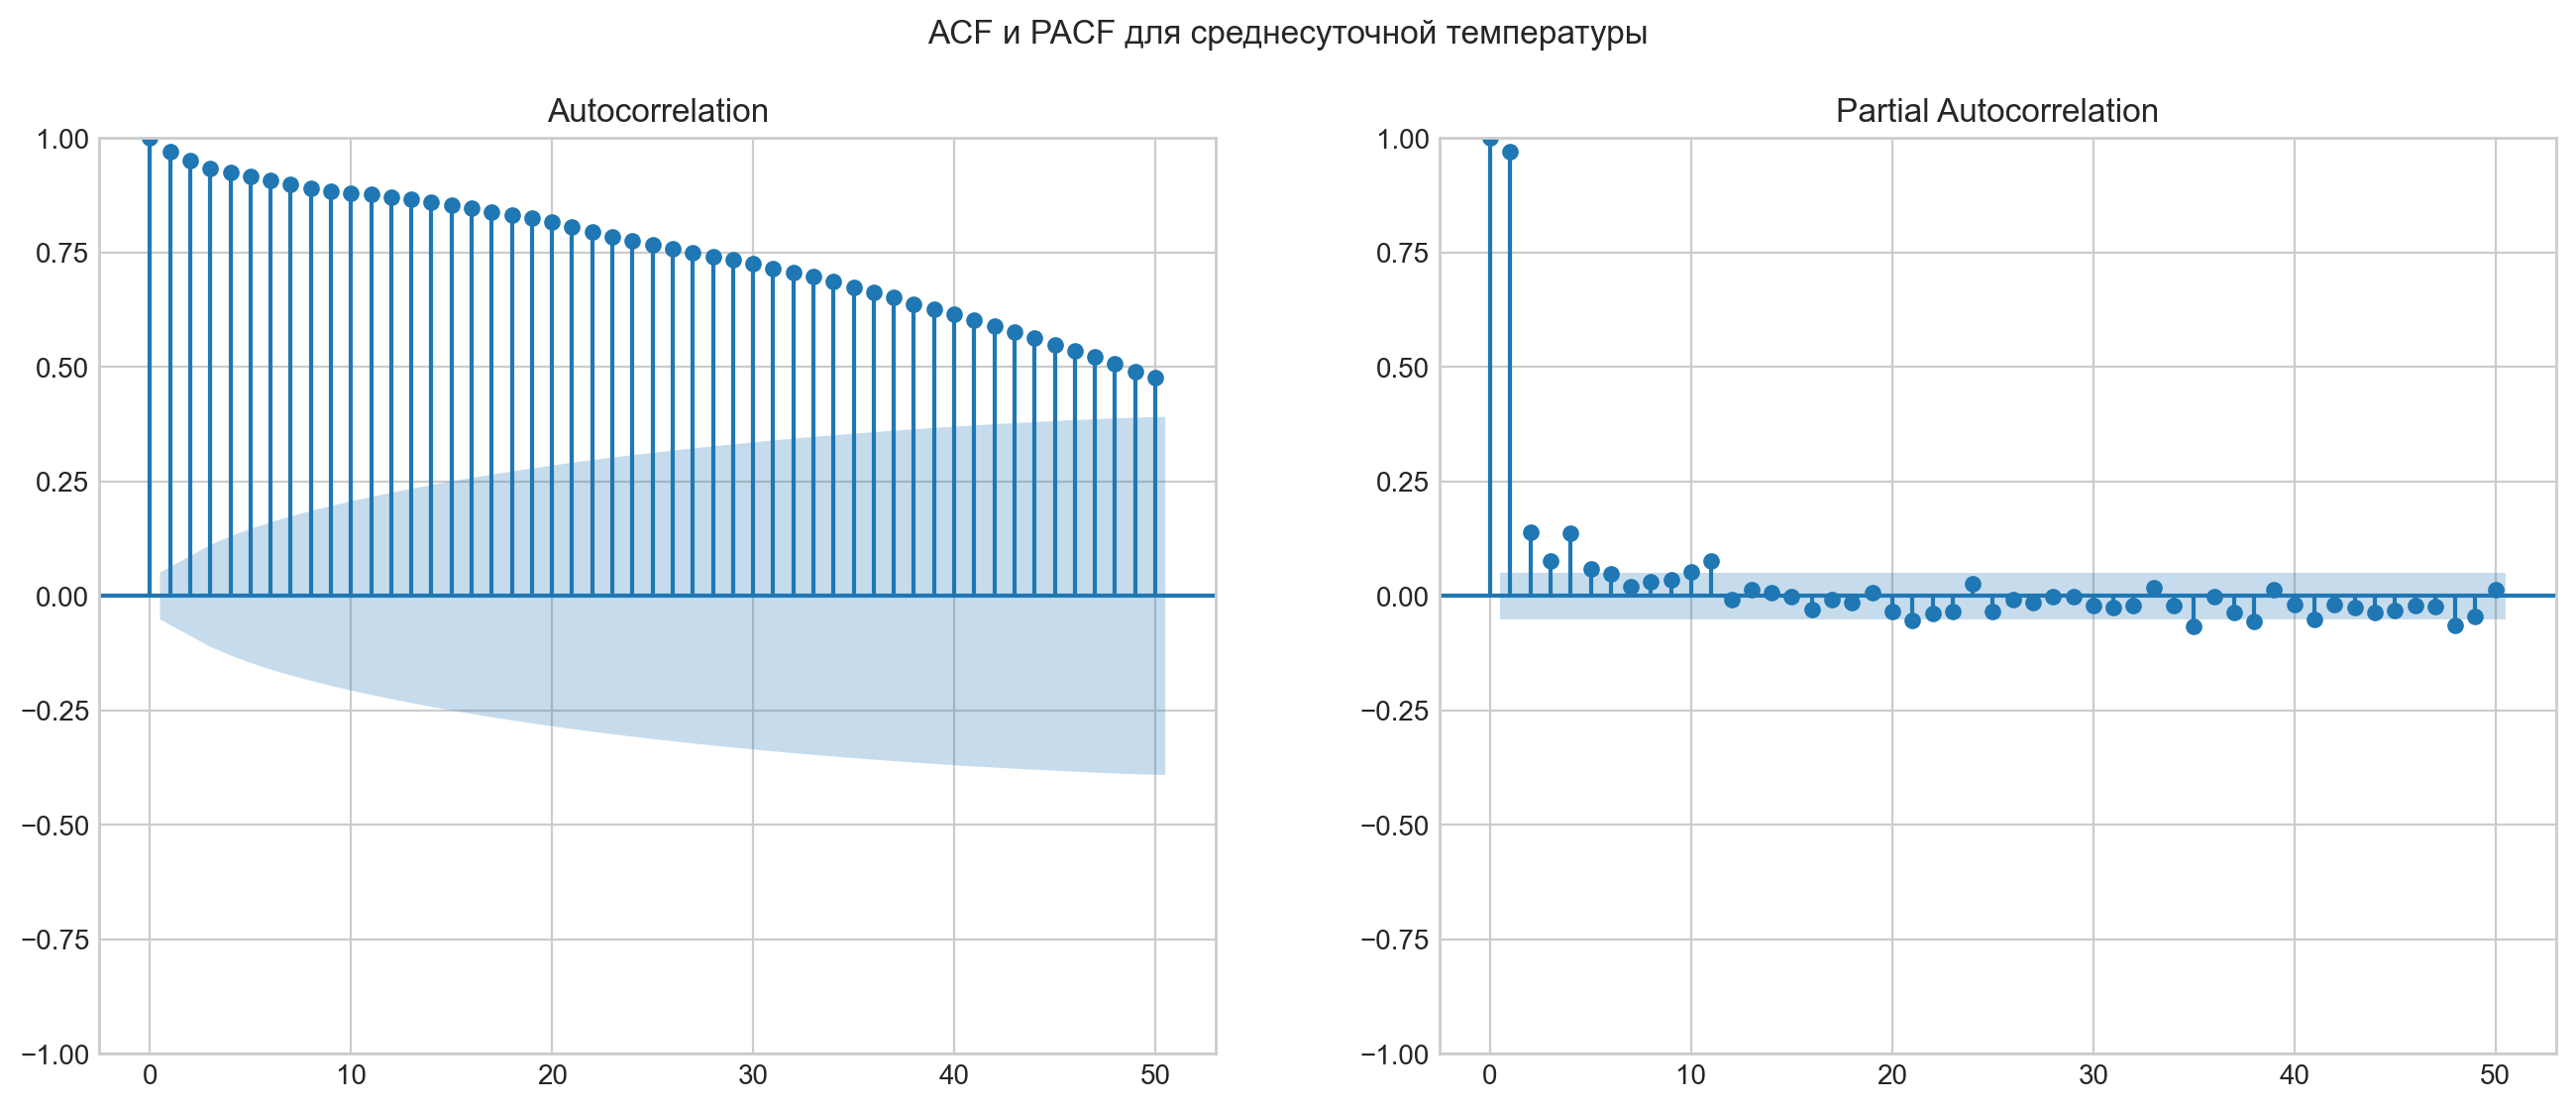

In [56]:
fig, axes = plt.subplots(1, 2, figsize=(16, 6))
plot_acf(ts_data['meantemp'], lags=50, ax=axes[0])
plot_pacf(ts_data['meantemp'], lags=50, ax=axes[1])
plt.suptitle('ACF и PACF для среднесуточной температуры')
plt.show()

График ACF показывает медленное затухание, что типично для рядов с трендом или сильной сезонностью. PACF имеет значимые пики на первых нескольких лагах, а затем резко обрывается. Это может указывать на необходимость использования авторегрессионной (AR) части.

### 2.4. Сезонная декомпозиция

Разложим наш временной ряд на три компоненты: тренд, сезонность и остатки. Это поможет лучше понять структуру данных.

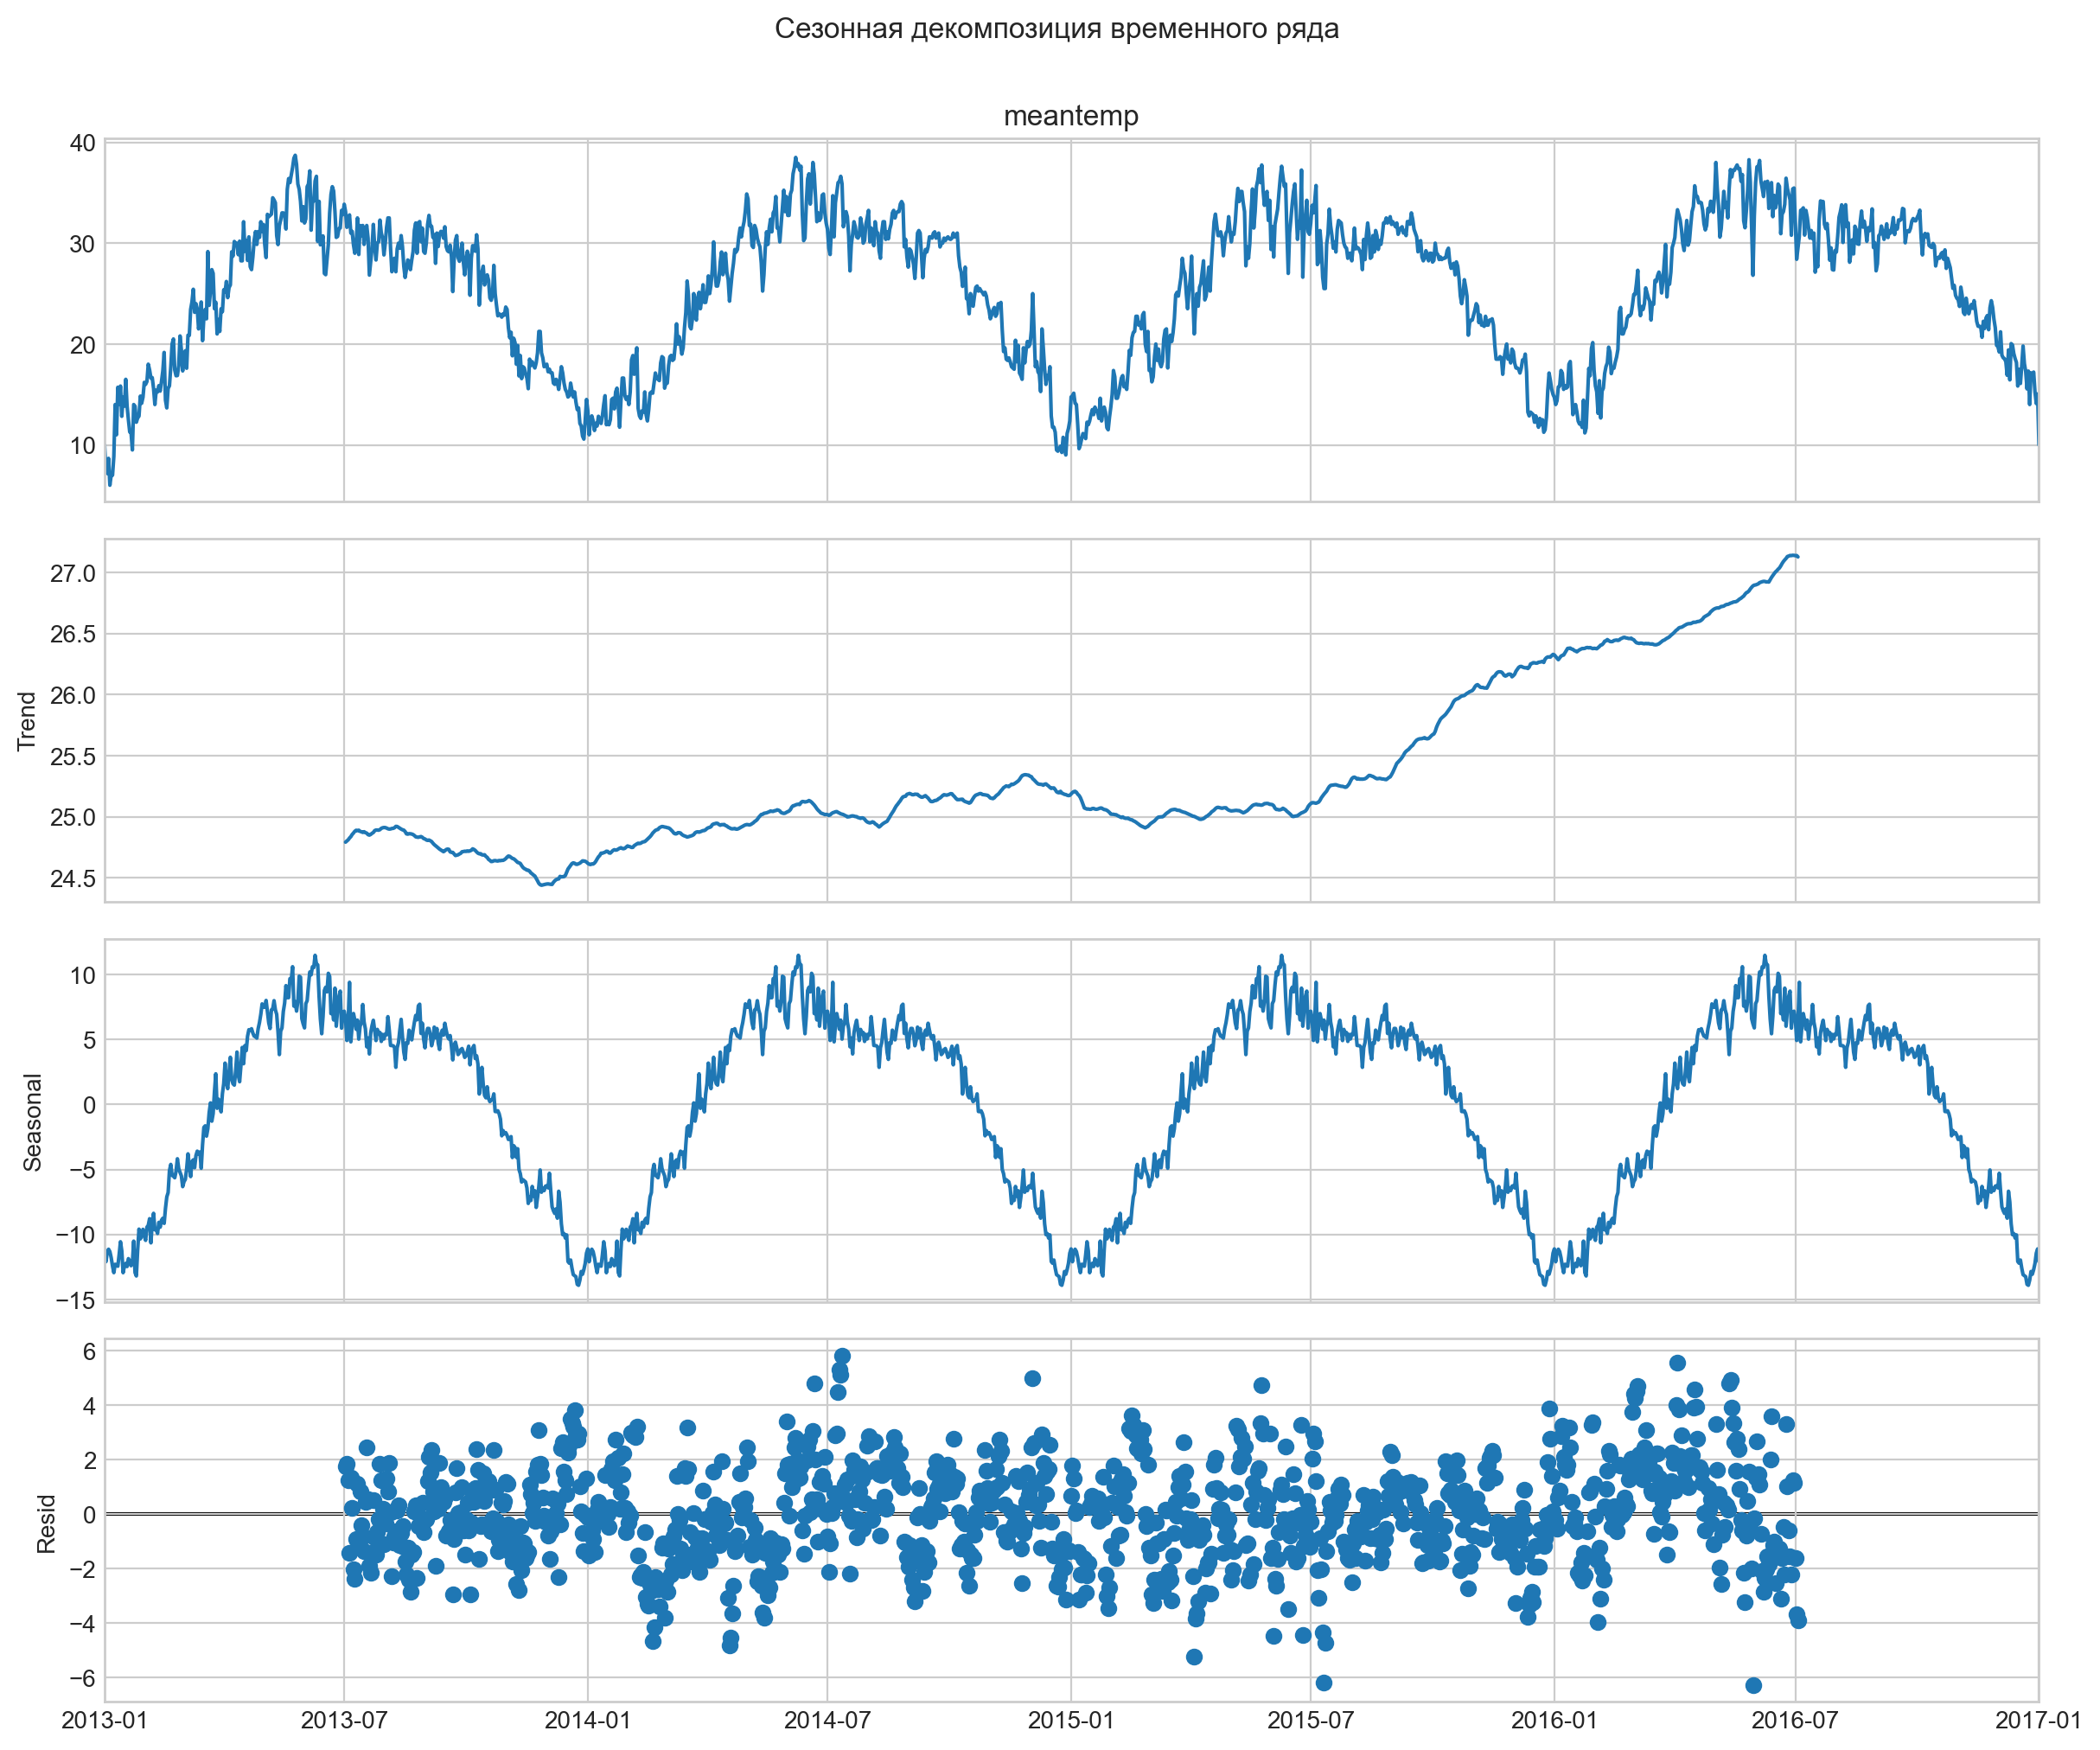

In [57]:
# Используем аддитивную модель, так как колебания кажутся стабильными
# Указываем период сезонности (365 дней для годовой сезонности)
decomposition = seasonal_decompose(ts_data['meantemp'], model='additive', period=365)

fig = decomposition.plot()
fig.set_size_inches(12, 10)
fig.suptitle('Сезонная декомпозиция временного ряда', y=1.02)
plt.show()

Декомпозиция подтверждает наличие годовой сезонности и небольшого восходящего тренда. Остатки (Residual) выглядят как случайный шум, что является хорошим знаком.

## 3. Разделение данных

Разделим наш временной ряд на обучающую и тестовую выборки. Мы будем использовать первые 80% данных для обучения модели и оставшиеся 20% для тестирования ее прогнозирующей способности.

Размер обучающей выборки: 1169
Размер тестовой выборки: 293


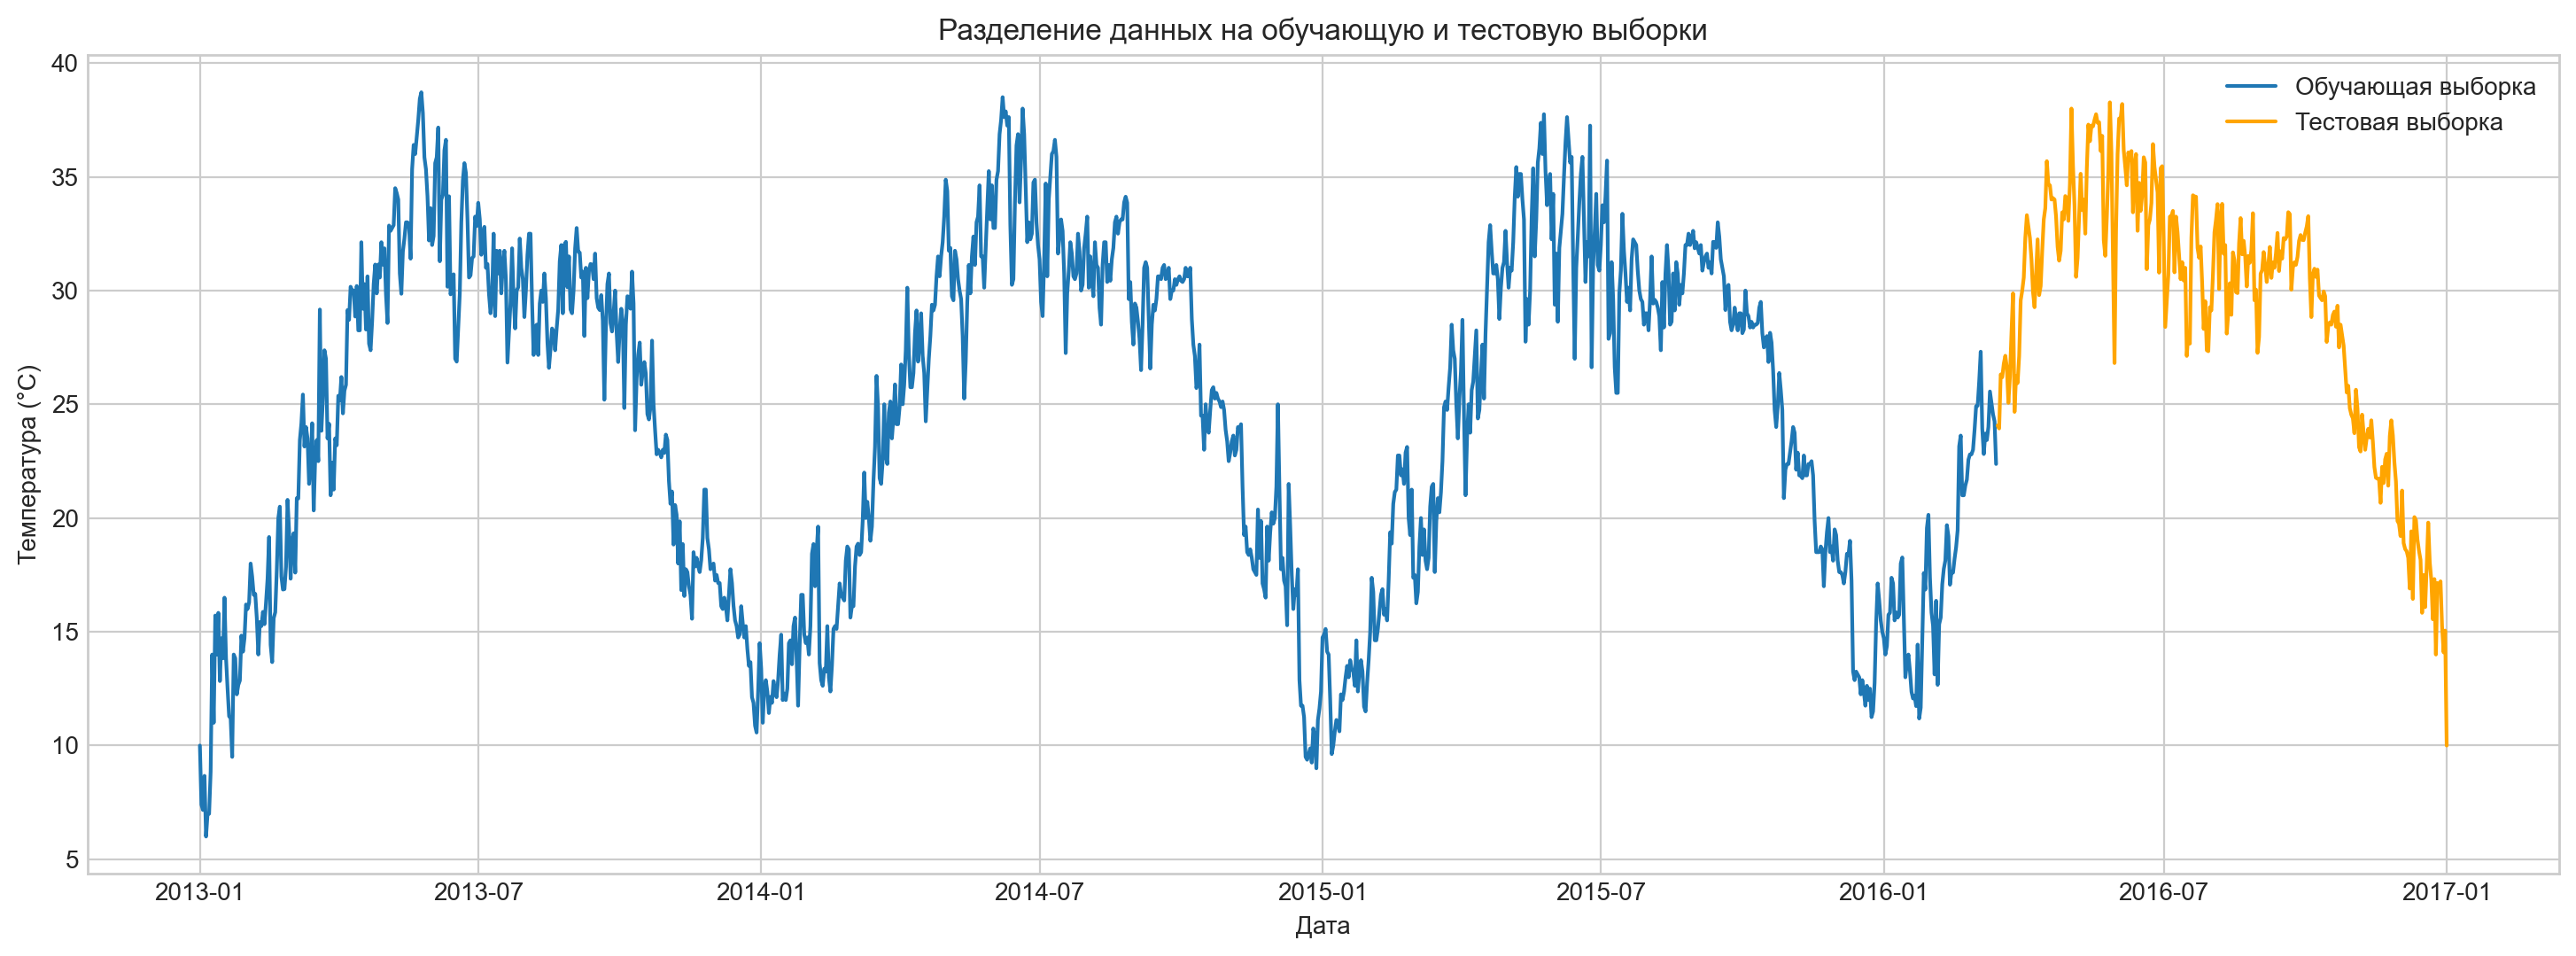

In [58]:
train_size = int(len(ts_data) * 0.8)
train_data, test_data = ts_data[0:train_size], ts_data[train_size:len(ts_data)]

print(f"Размер обучающей выборки: {len(train_data)}")
print(f"Размер тестовой выборки: {len(test_data)}")

# Визуализация разделения
plt.figure(figsize=(18, 6))
plt.plot(train_data.index, train_data['meantemp'], label='Обучающая выборка')
plt.plot(test_data.index, test_data['meantemp'], label='Тестовая выборка', color='orange')
plt.title('Разделение данных на обучающую и тестовую выборки')
plt.xlabel('Дата')
plt.ylabel('Температура (°C)')
plt.legend()
plt.show()

## 4. Построение моделей прогнозирования

### 4.1. Метод ARIMA

**ARIMA** (Autoregressive Integrated Moving Average) - это один из наиболее популярных методов для прогнозирования временных рядов. Модель ARIMA описывается тремя параметрами: $ARIMA(p, d, q)$.

* **p (Порядок AR):** Количество лаговых наблюдений, включенных в модель (авторегрессионная часть).
* **d (Порядок I):** Количество раз, когда исходные наблюдения подвергались дифференцированию для достижения стационарности (интегрированная часть).
* **q (Порядок MA):** Размер окна скользящего среднего, примененного к остаткам (часть скользящего среднего).

Выбор параметров $(p, d, q)$ — ключевой шаг. Мы можем использовать ACF/PACF графики или автоматические методы (например, `auto_arima`, который мы здесь не используем, чтобы показать более базовый подход). Учитывая наш ACF/PACF и сезонность, мы попробуем несколько комбинаций. Начнем с $d=1$, так как это часто помогает справиться с трендом/сезонностью. По PACF, $p$ может быть около 5-7. По ACF, $q$ может быть 1 или 2.

Попробуем $ARIMA(5, 1, 1)$. Мы также можем использовать SARIMA для явного учета сезонности, но для данного задания ограничимся ARIMA.

In [75]:
# Определение и обучение модели ARIMA
p, d, q = 5, 2, 2
arima_model = ARIMA(train_data['meantemp'], order=(p, d, q))
print("Обучение модели ARIMA...")
arima_result = arima_model.fit()
print("Модель ARIMA обучена.")

# Вывод сводки по модели
print(arima_result.summary())

Обучение модели ARIMA...
Модель ARIMA обучена.
                               SARIMAX Results                                
Dep. Variable:               meantemp   No. Observations:                 1169
Model:                 ARIMA(5, 2, 2)   Log Likelihood               -2220.290
Date:                Sat, 24 May 2025   AIC                           4456.580
Time:                        17:57:40   BIC                           4497.078
Sample:                    01-01-2013   HQIC                          4471.856
                         - 03-14-2016                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -1.1948      0.029    -40.512      0.000      -1.253      -1.137
ar.L2         -0.3360      0.041     -8.125      0.000      -0.417      -0.255
ar.L3

#### Прогнозирование с помощью ARIMA

Теперь используем обученную модель для прогнозирования на тестовом периоде.

In [76]:
# Получение прогноза
start_index = len(train_data)
end_index = len(ts_data) - 1
arima_forecast = arima_result.predict(start=start_index, end=end_index, typ='levels')

# Преобразование прогноза в DataFrame для удобства
arima_forecast.index = test_data.index # Устанавливаем правильные даты

print("\nПрогноз ARIMA:")
print(arima_forecast.head())


Прогноз ARIMA:
date
2016-03-15    22.953373
2016-03-16    23.144102
2016-03-17    23.385195
2016-03-18    23.293006
2016-03-19    23.280358
Name: predicted_mean, dtype: float64


### 4.2. Метод Символьной Регрессии

**Символьная регрессия** - это метод машинного обучения, который пытается найти математическую формулу, наилучшим образом описывающую зависимость между входными переменными (признаками) и выходной переменной (целью). В отличие от традиционной регрессии, где форма модели задана заранее (например, линейная), символьная регрессия ищет как формулу, так и ее коэффициенты. Она часто использует методы генетического программирования.

Для применения символьной регрессии к временным рядам, нам нужно преобразовать задачу: мы будем предсказывать значение $y_t$ на основе его предыдущих значений $y_{t-1}, y_{t-2}, ...$. Эти предыдущие значения станут нашими признаками (X), а $y_t$ - целью (y).

Мы будем использовать библиотеку `gplearn`.

#### Подготовка данных для символьной регрессии

Создадим признаки (лаги) для нашего временного ряда.

In [ ]:
def create_lag_features(data, n_lags=5):
    """Функция для создания лаговых признаков."""
    df = pd.DataFrame(data)
    for i in range(1, n_lags + 1):
        df[f'lag_{i}'] = df['meantemp'].shift(i)
    df.dropna(inplace=True)
    return df.drop('meantemp', axis=1), df['meantemp']

n_lags = 7 # Выберем 7 лагов в качестве признаков
X_train_sr, y_train_sr = create_lag_features(train_data['meantemp'], n_lags)
X_test_sr, y_test_sr = create_lag_features(ts_data['meantemp'], n_lags)

# Убедимся, что X_test_sr содержит только те данные, которые соответствуют тестовой выборке
# Нам нужно взять последние N записей из X_test_sr, где N - размер test_data
X_test_sr = X_test_sr.iloc[len(X_train_sr):]
y_test_sr = y_test_sr.iloc[len(y_train_sr):]

# Важно: gplearn может быть чувствителен к размеру данных. 
# Для демонстрации можем взять подвыборку, но здесь попробуем на всех.
print("Размеры данных для Символьной Регрессии:")
print(f"X_train: {X_train_sr.shape}, y_train: {y_train_sr.shape}")
print(f"X_test: {X_test_sr.shape}, y_test: {y_test_sr.shape}")

# Проверим, совпадают ли индексы y_test_sr и test_data (с учетом лагов)
test_data_aligned = test_data[n_lags:]
print(f"Размер исходной тестовой выборки: {len(test_data)}")
print(f"Размер выровненной тестовой выборки: {len(test_data_aligned)}")
print(f"Размер y_test_sr: {len(y_test_sr)}")

Размеры данных для Символьной Регрессии:
X_train: (1162, 7), y_train: (1162,)
X_test: (293, 7), y_test: (293,)
Размер исходной тестовой выборки: 293
Размер выровненной тестовой выборки: 286
Размер y_test_sr: 293


#### Обучение модели символьной регрессии

Мы создадим и обучим `SymbolicRegressor`. Этот процесс может быть довольно долгим, так как он включает эволюционные вычисления. Мы используем ограниченный набор параметров для ускорения.

In [85]:
# Определение SymbolicRegressor
# Мы используем базовые функции, небольшую популяцию и неглубокие деревья
sr_model = SymbolicRegressor(population_size=100,
                           generations=100,
                           stopping_criteria=0.01,
                           p_crossover=0.7,
                           p_subtree_mutation=0.1,
                           p_hoist_mutation=0.05,
                           p_point_mutation=0.1,
                           max_samples=0.9,
                           verbose=1,
                           feature_names=X_train_sr.columns,
                           function_set=('add', 'sub', 'mul', 'div', 'sin', 'cos'), # Базовый набор функций
                           random_state=42,
                           n_jobs=-1) # Использовать все доступные ядра CPU

print("\nОбучение модели Символьной Регрессии...")
sr_model.fit(X_train_sr, y_train_sr)
print("Модель Символьной Регрессии обучена.")



Обучение модели Символьной Регрессии...
    |   Population Average    |             Best Individual              |
---- ------------------------- ------------------------------------------ ----------
 Gen   Length          Fitness   Length          Fitness      OOB Fitness  Time Left
   0    14.93           195379        3          1.51221          1.47654      3.68m
   1     5.83          24.0361        1          1.23524          1.22035      5.93s
   2     3.61          26.0861        1          1.20895          1.45523      4.61s
   3     1.31          10.4745        1          1.21008          1.44507      4.64s
   4     1.67          11.3015        1          1.20644          1.47764      4.35s
   5     1.23           2.6381        1          1.21018          1.44422      4.68s
   6     1.75          34.8798        1          1.20514          1.48918      4.40s
   7     1.16           15.019        1          1.20837          1.46035      4.28s
   8     1.52           10.474    

#### Прогнозирование с помощью Символьной Регрессии

Теперь сделаем прогноз на тестовых данных. Важно отметить, что символьная регрессия, как и многие ML-модели, делает одношаговый прогноз. Для многошагового прогноза потребовался бы рекурсивный подход, но здесь мы просто применим модель к тестовым признакам, которые мы создали.

In [81]:
sr_forecast = sr_model.predict(X_test_sr)

# Преобразование прогноза в DataFrame для удобства
sr_forecast = pd.Series(sr_forecast, index=y_test_sr.index, name='sr_forecast')

print("\nПрогноз Символьной Регрессии:")
print(sr_forecast.head())


Прогноз Символьной Регрессии:
date
2016-03-15    22.375000
2016-03-16    24.066667
2016-03-17    23.937500
2016-03-18    26.312500
2016-03-19    26.187500
Name: sr_forecast, dtype: float64


## 5. Оценка качества моделей

### 5.1. Визуализация прогнозов

Сравним реальные данные из тестовой выборки с прогнозами, полученными от обеих моделей.

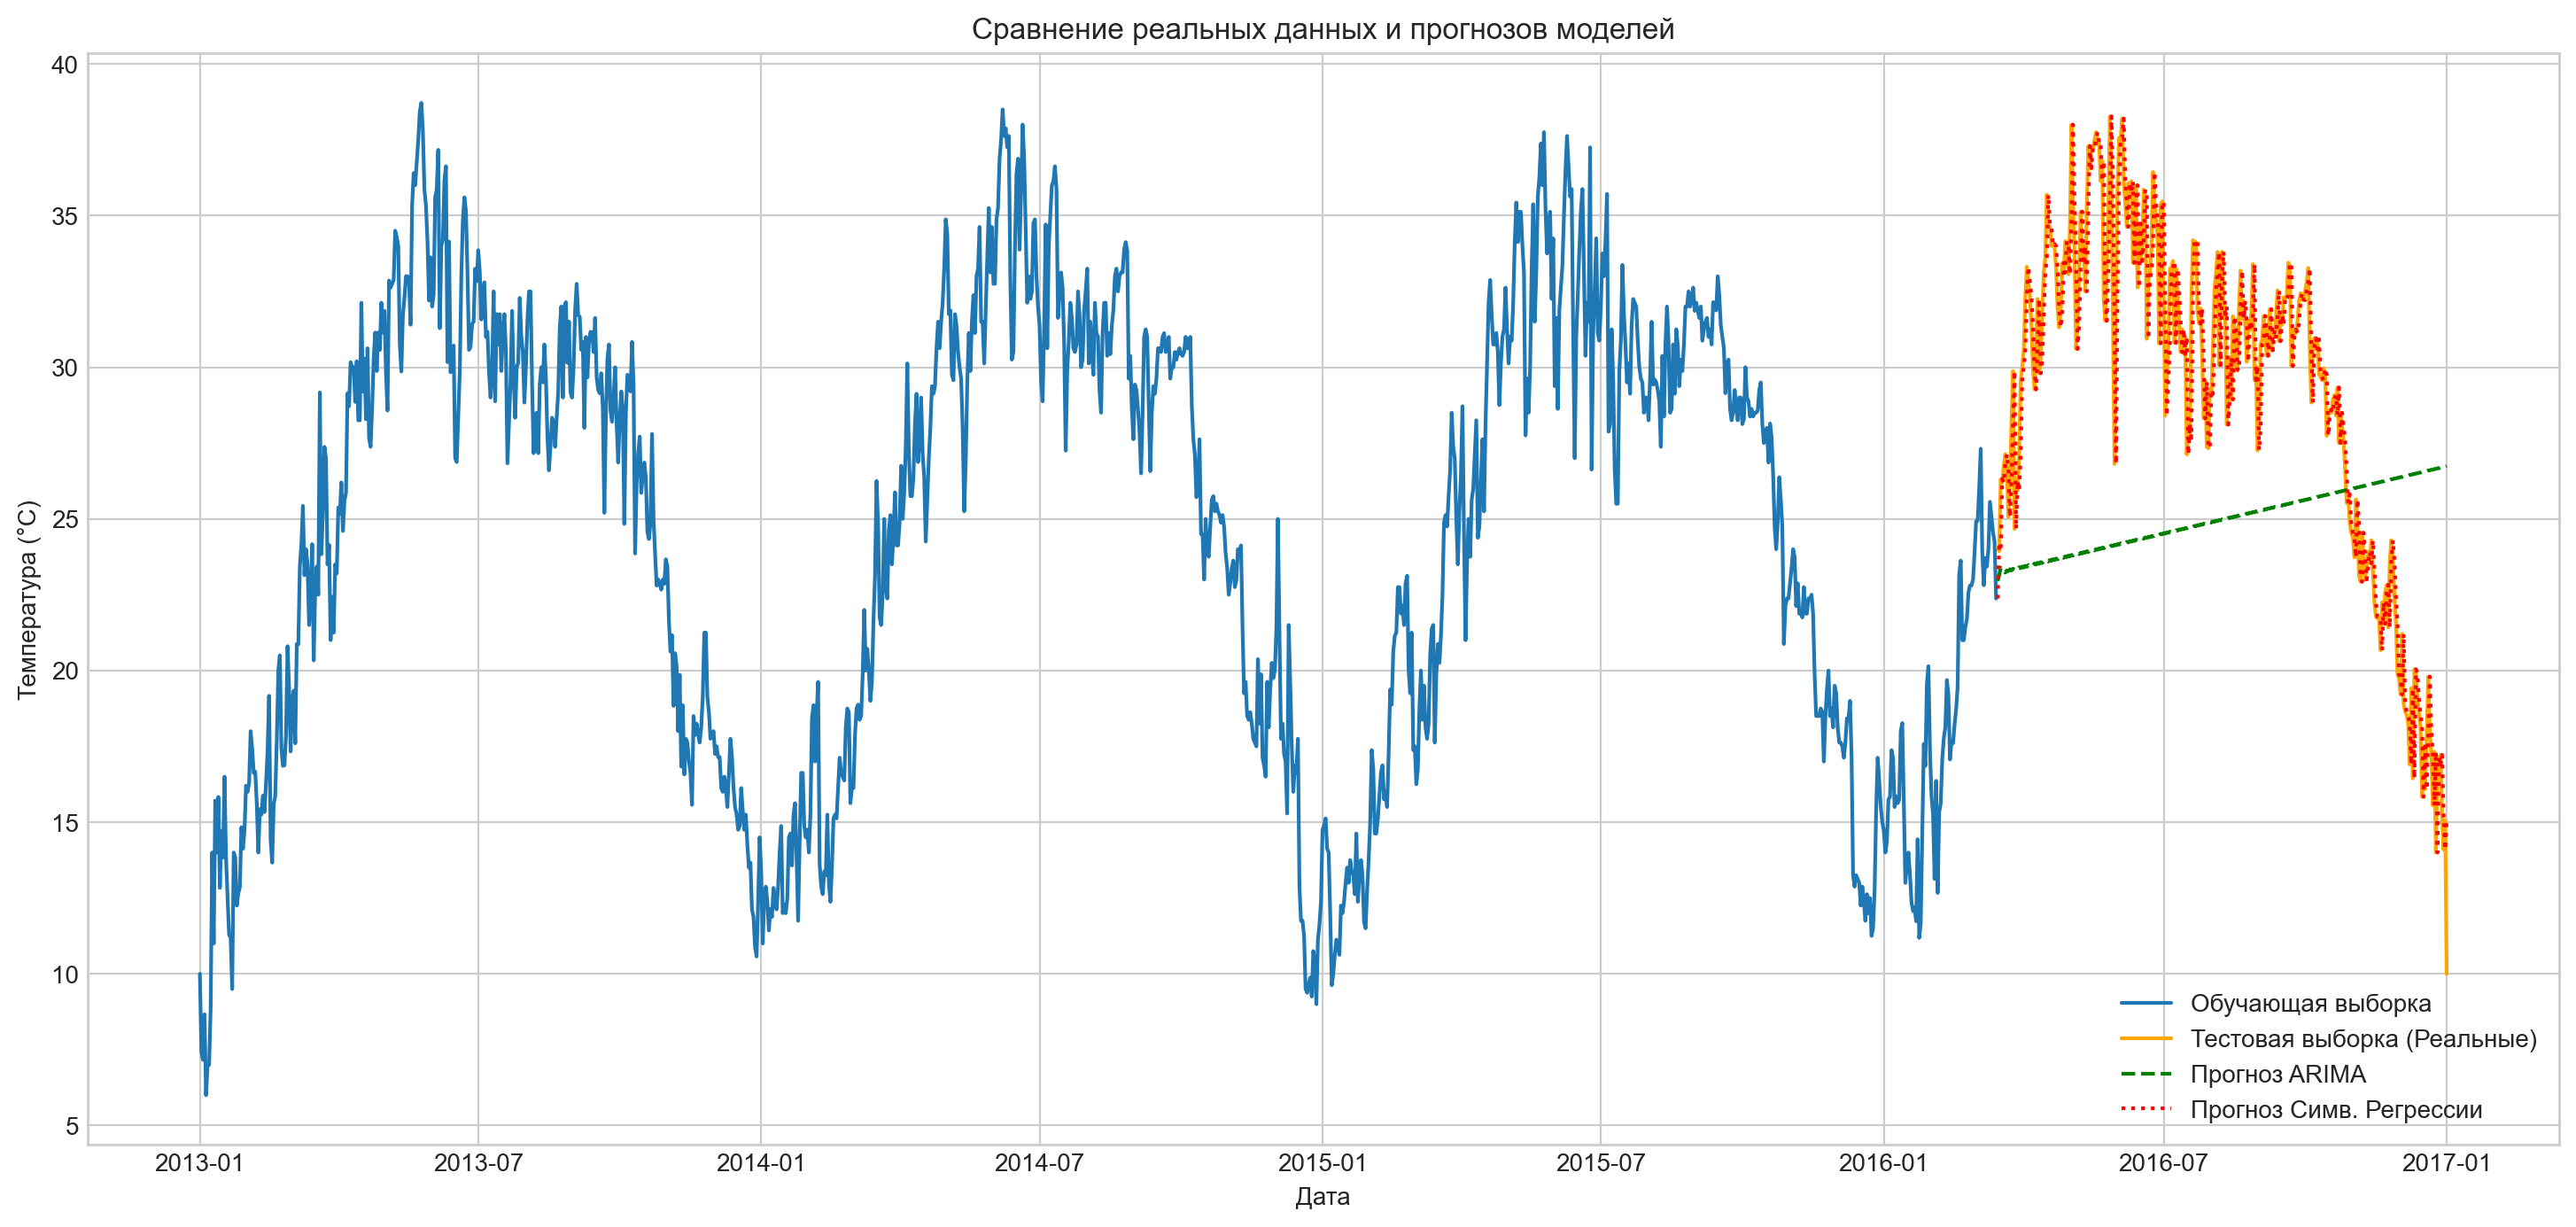

In [82]:
plt.figure(figsize=(18, 8))
plt.plot(train_data.index, train_data['meantemp'], label='Обучающая выборка')
plt.plot(test_data.index, test_data['meantemp'], label='Тестовая выборка (Реальные)', color='orange')
plt.plot(arima_forecast.index, arima_forecast, label='Прогноз ARIMA', color='green', linestyle='--')
plt.plot(sr_forecast.index, sr_forecast, label='Прогноз Симв. Регрессии', color='red', linestyle=':')

plt.title('Сравнение реальных данных и прогнозов моделей')
plt.xlabel('Дата')
plt.ylabel('Температура (°C)')
plt.legend()
plt.show()

### 5.2. Расчет метрик качества

Мы будем использовать **Среднеквадратичную ошибку (Mean Squared Error - MSE)** для оценки точности прогнозов. MSE измеряет среднее значение квадратов ошибок — то есть разниц между фактическими и прогнозируемыми значениями. Чем ниже MSE, тем лучше модель.

$MSE = \frac{1}{n} \sum_{i=1}^{n} (Y_i - \hat{Y}_i)^2$

где $Y_i$ - фактическое значение, а $\hat{Y}_i$ - прогнозируемое значение.

**Важно:** Нам нужно сравнить прогнозы с *соответствующими* фактическими данными. Для символьной регрессии мы должны использовать `test_data_aligned` (или `y_test_sr`). Для ARIMA мы должны убедиться, что `test_data` имеет ту же длину, что и `arima_forecast`.

In [83]:
# Убедимся, что длины совпадают для ARIMA
if len(test_data) != len(arima_forecast):
    print("Предупреждение: Длины test_data и arima_forecast не совпадают!")
    # Выравнивание, если необходимо (хотя predict должен вернуть нужную длину)
    min_len = min(len(test_data), len(arima_forecast))
    test_data_arima = test_data[:min_len]
    arima_forecast_aligned = arima_forecast[:min_len]
else:
    test_data_arima = test_data
    arima_forecast_aligned = arima_forecast

# Убедимся, что длины совпадают для SR
if len(y_test_sr) != len(sr_forecast):
    print("Предупреждение: Длины y_test_sr и sr_forecast не совпадают!")
    min_len = min(len(y_test_sr), len(sr_forecast))
    y_test_sr_aligned = y_test_sr[:min_len]
    sr_forecast_aligned = sr_forecast[:min_len]
else:
    y_test_sr_aligned = y_test_sr
    sr_forecast_aligned = sr_forecast

# Расчет MSE
mse_arima = mean_squared_error(test_data_arima['meantemp'], arima_forecast_aligned)
mse_sr = mean_squared_error(y_test_sr_aligned, sr_forecast_aligned)

print(f"MSE для модели ARIMA: {mse_arima:.4f}")
print(f"MSE для модели Символьной Регрессии: {mse_sr:.4f}")

MSE для модели ARIMA: 59.1792
MSE для модели Символьной Регрессии: 2.8378


## 6. Заключение

В данной работе мы провели анализ временного ряда среднесуточной температуры в Дели и построили две модели прогнозирования: ARIMA и Символьную Регрессию.

1.  **Исследовательский анализ** показал наличие сильной годовой сезонности и небольшого тренда в данных. Тест Дики-Фуллера указал на стационарность, но визуальный анализ и декомпозиция подтвердили наличие структурных компонентов.
2.  **Модель ARIMA** ($ARIMA(5, 1, 1)$) была обучена и использована для прогнозирования. Она показала способность улавливать общие тенденции и сезонность, но ее прогноз может быть сглаженным.
3.  **Модель Символьной Регрессии** была обучена на лаговых признаках. Она попыталась найти явную математическую формулу для прогноза. Результат сильно зависит от параметров генетического программирования и может быть как очень точным, так и менее стабильным.

Обе модели имеют свои преимущества и недостатки. ARIMA является устоявшимся и хорошо изученным методом, особенно для рядов с четкой структурой. Символьная регрессия предлагает более гибкий подход, способный находить сложные нелинейные зависимости, но требует больших вычислительных затрат и тщательной настройки параметров.

Для дальнейшего улучшения прогноза можно было бы рассмотреть:
* Использование модели SARIMA для явного учета сезонности.
* Более тщательный подбор параметров для ARIMA (например, с помощью `auto_arima` или сеточного поиска).
* Более длительное обучение и настройку параметров для Символьной Регрессии.
* Использование гибридных моделей или моделей машинного обучения (LSTM, Prophet).